Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [55]:
# Imports


import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeCV, RidgeClassifier, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor, XGBClassifier

In [83]:
# Wrangle Data

pd.set_option('display.max_rows', 150)

def readIn(file, parse_d='DATE', idx='DATE'):
    """ Opens .csv file, creates datetime index, and returns DataFrame"""

    DATA_PATH = '../data/build_finance/'
    df = pd.read_csv(DATA_PATH+file,
                     parse_dates=[parse_d]).set_index(idx)
    return df


def manyToOne(files_m, files_q, file_w):
    """Accepts lists of .csv files and returns single DataFrame"""

    # Takes monthly and quarterly files, has them read_in, parses their
    # dates, and return DataFrames held in lists
    frames_m = [readIn(file) for file in files_m]
    frames_q = [readIn(file) for file in files_q]

    # Reads in SP500 data, indicates columns to use, and capitalizes 'DATE'
    # for consistency with other DataFrames held in frames_m and frames_q
    DATA_PATH = '../data/build_finance/'
    sp = pd.read_csv(DATA_PATH+file_w, usecols=['Date', 'Close'],
                     parse_dates=['Date']).set_index('Date')
    sp.rename(columns={'Date': 'DATE', 'Close': 'SP500_CLOSE'}, inplace=True)

    # Concatenate DataFrames held in frames_m and frames_q
    concat_m = pd.concat(frames_m, axis=1)
    concat_q = pd.concat(frames_q, axis=1)

    # Final concatenation of all DataFrames (monthly data, quarterly data 
    # and SP500 data)
    last = pd.concat([concat_m, concat_q, sp], axis=1)

    # SP500 data is only available from 1/1/1985
    # Mask out dates prior to January 1st, 1985
    mask = last.index >= '1985-01-01'
    df_final = last[mask]
    df_final.shape

    # Return DataFrame
    return df_final


def wrangle(files_m, files_q, file_w):
    # Pass .csv files and have a single DataFrame returned
    df = manyToOne(files_m, files_q, file_w)

    # Rename columns
    df.columns = ['cpi', '10yr_treasury', 'housing_starts', 
                  'industrial_prod', 'initial_claims', 'unemployment_rate', 
                  'corp_profits', 'exports_goods_svs', 'gdp', 'net_exports',
                  'sp500_close']

    # Reorganize columns
    cols_reorder = ['net_exports', '10yr_treasury', 'corp_profits', 
                    'gdp', 'exports_goods_svs', 'cpi', 'industrial_prod', 
                    'unemployment_rate', 'initial_claims', 'housing_starts', 
                    'sp500_close']

    df = df.reindex(columns=cols_reorder)

    # Create a target feature, month-ahead-return: positive/negative - 
    # Binary Classification
    #df['sp_ahead_pos_neg'] = (df['sp500_close'].shift(-1) - df['sp500_close']) > 0

    # Drop leaky feature
    #df.drop(columns='sp500_close', inplace=True)

    # Forward fill the quarterly data
    df.ffill(inplace=True)

    # Create new feature the shows the montly change in monthly initial unemployment 
    # claims
    df['change_initial_claims'] = 1 - (df['initial_claims'] / df['initial_claims'].shift(+1))

    # Drop 'initial_claims'
    df.drop(columns='initial_claims')
    low_correlation_features = ['unemployment_rate', 'initial_claims', 'housing_starts', 'change_initial_claims']
    df.drop(columns=low_correlation_features, inplace=True)

    # Return wrangled DataFrame
    return df


file_w = '^GSPC_m.csv'

files_m = ['CPI.csv',
           'DGS10.csv',
           'HOUST.csv',
           'INDPRO.csv',
           'INITCLMS.csv',
           'UNRATE.csv']

files_q = ['CP.csv',
           'EXPGS.csv',
           'GDP.csv',
           'NETEXP.csv',]


#df = manyToOne(files_m, files_q, file_w)

df = wrangle(files_m, files_q, file_w)
print(df.shape)
df.tail(10)

(427, 8)


,net_exports,10yr_treasury,corp_profits,gdp,exports_goods_svs,cpi,industrial_prod,sp500_close
2019-10-01,-549.757,1.706818,2000.736,19253.959,2515.671,257.387,109.0270,3037.560059
2019-11-01,-549.757,1.812105,2000.736,19253.959,2515.671,257.989,110.0388,3140.979980
2019-12-01,-549.757,1.862857,2000.736,19253.959,2515.671,258.203,109.6527,3230.780029
2020-01-01,-494.307,1.757619,1739.103,19010.848,2438.710,258.687,109.1845,3225.520020
2020-02-01,-494.307,1.504211,1739.103,19010.848,2438.710,258.824,109.2966,2954.219971
2020-03-01,-494.307,0.870000,1739.103,19010.848,2438.710,257.989,104.5221,2584.590088
2020-04-01,-545.164,0.657619,1557.064,17302.511,1788.166,256.192,91.2658,2912.429932
2020-05-01,-545.164,0.674000,1557.064,17302.511,1788.166,255.942,92.0613,3044.310059
2020-06-01,-545.164,0.728636,1557.064,17302.511,1788.166,257.282,97.8019,3100.290039
2020-07-01,-736.124,0.623636,2118.856,18596.521,2071.577,258.604,101.9086,3271.120117


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 1985-01-01 to 2020-07-01
Freq: MS
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   net_exports        427 non-null    float64
 1   10yr_treasury      427 non-null    float64
 2   corp_profits       427 non-null    float64
 3   gdp                427 non-null    float64
 4   exports_goods_svs  427 non-null    float64
 5   cpi                427 non-null    float64
 6   industrial_prod    427 non-null    float64
 7   sp500_close        427 non-null    float64
dtypes: float64(8)
memory usage: 30.0 KB


<AxesSubplot:>

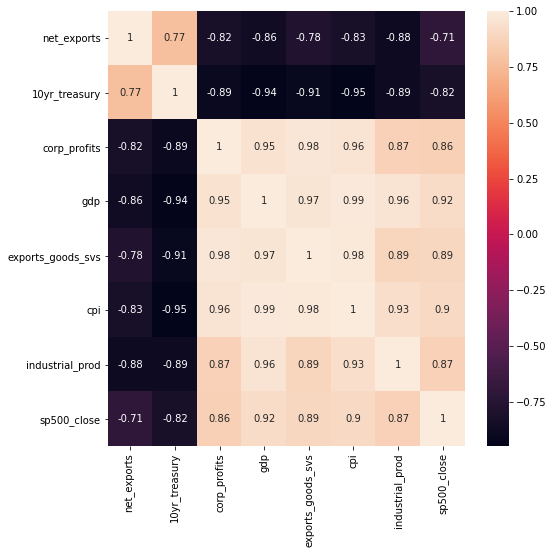

In [85]:
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(df.corr(), annot = True)

In [ ]:
useful_features ['corp_profits', 'exports_goods_svs', 'net_exports', 'gdp', '10-yr_treasury', 'cpi', 'industrial_production']
low_correlation_features = ['unemployment_rate', 'initial_claims', 'housing_starts', 'change_initial_claims']

In [4]:
# Create a Feature Matrix and Target Vector
target = 'sp_ahead_pos_neg'

y = df[target]
X = df.drop(columns='sp_ahead_pos_neg')

print(X.shape, y.shape)

(427, 11) (427,)


In [5]:
# Split the data = create train and test sets 
# Will use 5-fold cross-validation with our training set

mask = df.index < '2014-01-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(348, 11) (348,)
(79, 11) (79,)


In [6]:
# Let's look at the distribution of the target variable, 'sp_ahead_pos_neg', and determine our 
# majority class - the market has been up in the month ahead about 62.93% of the time.
# There is no gross overweighting of our classes, and we can use accuracy score to assess.
# We will also explore precision/recall and ROC-AUC curves for multiple models. 

baseline_outcomes = y_train.value_counts(normalize=True)*100
print(f'The majority class is True - "The Market Went Up"')
print(f'Our basline accuracy score is {baseline_outcomes[1]:.2f}%')

The majority class is True - "The Market Went Up"
Our basline accuracy score is 62.93%


In [7]:
# Logistic Regression 
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [8]:
model_lr.score(X_train, y_train)

0.6551724137931034

In [9]:
# Random Forest Classifier 
model_rf = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier()
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [10]:
model_rf.score(X_train, y_train)

1.0

In [11]:
# Let's look at some interesting hyperparameters and tune the Logistic Regression model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=22),
)

params = {'logisticregression__C': range(1, 21, 5),
          'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__max_iter': range(10, 201, 10)}

model_rs_lr = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=22))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'logisticregression__C': range(1, 21, 5),
                                        'logisticregression__max_iter': range(10, 201, 10),
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear',
                                                                       'sag',
                                                                     

In [12]:
model_rs_lr.best_params_

{'logisticregression__solver': 'liblinear',
 'logisticregression__max_iter': 180,
 'logisticregression__C': 1}

In [13]:
model_rs_lr.best_score_

0.6232298136645962

In [14]:
model_rs_lr.score(X_test, y_test)

0.6708860759493671

In [15]:
# Let's look at some interesting hyperparameters and tune the Random Forest model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=22),
)

params = {'randomforestclassifier__n_estimators': range(50, 301, 25),
          'randomforestclassifier__max_depth': range(5, 201, 5),
          'randomforestclassifier__max_features': ['sqrt', 'log2']}

model_rs_rf = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=22))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 201, 5),
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2'],
                                        'randomforestclassifier__n_estimators': range(50, 301, 25)},
                   verbose=1)

In [16]:
model_rs_rf.best_params_

{'randomforestclassifier__n_estimators': 275,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 5}

In [17]:
model_rs_rf.best_score_

0.5599999999999999

In [18]:
model_rs_rf.score(X_test, y_test)

0.5316455696202531

In [19]:
model_rc = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22)
)

model_rc.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier(random_state=22))])

In [20]:
model_rc.score(X_train, y_train)

0.6724137931034483

In [21]:
coefficients = model_rc.named_steps['ridgeclassifier'].coef_
feature_names = X_train.columns

feature_importances = pd.Series(coefficients[0], index=feature_names)
feature_importances

corp_profits             0.792814
exports_goods_svs       -0.243593
net_exports              0.321541
gdp                     -0.337018
10yr_treasury           -0.225611
cpi                      0.109662
industrial_prod         -0.175818
unemployment_rate       -0.227778
initial_claims           0.173785
housing_starts           0.160841
change_initial_claims    0.068000
dtype: float64

Text(0.5, 1.0, 'Feature Coefficients for Ridge Classifier model')

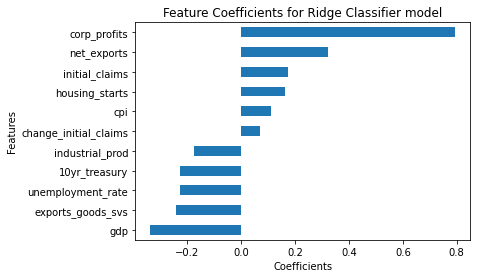

In [22]:
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Feature Coefficients for Ridge Classifier model')

In [23]:
# Let's look at some interesting hyperparameters and tune the Ridge Classifier model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22),
)

params = {'ridgeclassifier__alpha': range(1, 102, 10)}

model_gs_rc = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_gs_rc.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridgeclassifier',
                                        RidgeClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'ridgeclassifier__alpha': range(1, 102, 10)},
             verbose=1)

In [24]:
model_gs_rc.best_params_

{'ridgeclassifier__alpha': 101}

In [25]:
model_gs_rc.best_score_

0.6148654244306418

In [26]:
model_gs_rc.score(X_test, y_test)

0.6708860759493671

In [31]:
model_gs_rc.estimator.named_steps['ridgeclassifier'].coef_

AttributeError: 'RidgeClassifier' object has no attribute 'coef_'

In [ ]:
country_grp = df.groupby(['Country'])
country_grp['LanguageWorkedWith'].str.contains('Python').sum()
country_uses_python = country_grp['LanguageWorkedWIth'].apply(lambda x: x.str.contains('Python').sum())
country_uses_python = country_grp['LanguafeWorkedWith'].apply(lambda x: x.str.contains('Python').sum())

pyton_df = pd.concat(['country_respondents', 'country_uses_python'], axis='columns', sort=False)

In [27]:
model_XGBC = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(max_depth=5, learning_rate=0.01, 
                  n_estimators=2000, colsample_bytree=0.1,
                  n_jobs=-1, random_state=22)
)

model_XGBC.fit(X_train, y_train)

[19:40:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=2000,
                               n_jobs=-1, num_parallel_tree=1, random_state=22,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [28]:
model_XGBC.score(X_train, y_train)

0.9626436781609196

In [29]:
model_XGBC.score(X_test, y_test)

0.4936708860759494